*Goal*: 
1. find out if the dataset fits the data requirements
2. get interactions dataframe ['user_id', 'item_id', 'date'(%Y-%m), 'timetsamp']
2. get item meta dataframe ['item_id', meta_col('genre_id' or 'tag_id', etc...)]

*Data Requirements*:
* user activity is >80% of all time intervals
* month 1, user has >5 rates
* month 0, to pre-train model
* items are comparable
* timestamp
* implicit feedback
* ranking problem


*Conclusion*:

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
import pandas as pd 
import re
import numpy as np

from data_utils import getDF, getDF_n_lines, load_data
from dataset_evaluation_utils import * 

from datetime import datetime, timezone
import gzip
import json

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# paths

In [3]:
dataset_folderpath = '../datasets/goodreads/'

dataset_name = 'Goodreads'
dump_foldername ='goodreads_dump/'

# rule: what/which_data_set/sample_version/what/
images_path, output_path, heatmaps_path, diversity_graphpath, diversity_filepath = get_folderpaths(dump_foldername)

___

# Goodreads

https://mengtingwan.github.io/data/goodreads#datasets

## column names

In [4]:
inter_columns = ['user_id', 'item_id', 'date','timestamp']
# meta_col = ''
# item_meta_columns = ['item_id', meta_col]

In [ ]:
# takes 5min on my pc
orig_df = pd.read_csv(dataset_folderpath+'goodreads_interactions.csv')
orig_df


# snipet of datasets

In [6]:
orig_df

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0
...,...,...,...,...,...
228648337,876144,24772,0,0,0
228648338,876144,23847,1,4,0
228648339,876144,23950,1,3,0
228648340,876144,374106,1,5,1


In [4]:
load_data(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)

[{'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34684622',
  'review_id': 'a53868823f065a0e20fd4ae98b820674',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Tue Oct 17 09:40:11 -0700 2017',
  'date_updated': 'Tue Oct 17 09:40:12 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34536488',
  'review_id': '9f08c5f991f87f3b7ae4ce779c2aac10',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Fri Oct 13 07:19:50 -0700 2017',
  'date_updated': 'Fri Oct 13 07:19:50 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34017076',
  'review_id': '14da595c5b0c38b1247888f62f74a772',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Fri Oct 06 09:32:42 -0700 2017',
  'date_updated': 'Fri Oct 06 09:32:43 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'u

In [5]:
load_data(dataset_folderpath+'goodreads_book_authors.json.gz', head=3)

[{'average_rating': '3.98',
  'author_id': '604031',
  'text_reviews_count': '7',
  'name': 'Ronald J. Fields',
  'ratings_count': '49'},
 {'average_rating': '4.08',
  'author_id': '626222',
  'text_reviews_count': '28716',
  'name': 'Anita Diamant',
  'ratings_count': '546796'},
 {'average_rating': '3.92',
  'author_id': '10333',
  'text_reviews_count': '5075',
  'name': 'Barbara Hambly',
  'ratings_count': '122118'},
 {'average_rating': '3.68',
  'author_id': '9212',
  'text_reviews_count': '36262',
  'name': 'Jennifer Weiner',
  'ratings_count': '888522'}]

In [6]:
load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=3)

[{'book_id': '5333265',
  'genres': {'history, historical fiction, biography': 1}},
 {'book_id': '1333909',
  'genres': {'fiction': 219, 'history, historical fiction, biography': 5}},
 {'book_id': '7327624',
  'genres': {'fantasy, paranormal': 31,
   'fiction': 8,
   'mystery, thriller, crime': 1,
   'poetry': 1}},
 {'book_id': '6066819',
  'genres': {'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}}]

In [7]:
load_data(dataset_folderpath+'goodreads_book_series.json.gz', head=3)

[{'numbered': 'true',
  'note': '',
  'description': '',
  'title': 'Sun Wolf and Starhawk',
  'series_works_count': '9',
  'series_id': '189911',
  'primary_work_count': '3'},
 {'numbered': 'true',
  'note': '',
  'description': 'This series is also known as * Avalon : Jalinan Sihir (Bahasa Indonesia) See also the spin-off manga series \x01.',
  'title': 'Avalon: Web of Magic',
  'series_works_count': '14',
  'series_id': '151854',
  'primary_work_count': '12'},
 {'numbered': 'true',
  'note': '',
  'description': 'Plot-wise, "Crowner\'s Crusade" is a prequel to the series, but #15 in publication order.',
  'title': 'Crowner John Mystery',
  'series_works_count': '15',
  'series_id': '169353',
  'primary_work_count': '15'},
 {'numbered': 'true',
  'note': '',
  'description': '',
  'title': "Pluto's Snitch",
  'series_works_count': '3',
  'series_id': '1052227',
  'primary_work_count': '3'}]

In [8]:
load_data(dataset_folderpath+'goodreads_book_works.json.gz', head=3)

[{'books_count': '1',
  'reviews_count': '6',
  'original_publication_month': '8',
  'default_description_language_code': '',
  'text_reviews_count': '1',
  'best_book_id': '5333265',
  'original_publication_year': '1984',
  'original_title': 'W. C. Fields: A Life on Film',
  'rating_dist': '5:1|4:1|3:1|2:0|1:0|total:3',
  'default_chaptering_book_id': '',
  'original_publication_day': '',
  'original_language_id': '',
  'ratings_count': '3',
  'media_type': 'book',
  'ratings_sum': '12',
  'work_id': '5400751'},
 {'books_count': '22',
  'reviews_count': '10162',
  'original_publication_month': '',
  'default_description_language_code': '',
  'text_reviews_count': '741',
  'best_book_id': '25717',
  'original_publication_year': '2001',
  'original_title': 'Good Harbor',
  'rating_dist': '5:517|4:1787|3:2763|2:966|1:196|total:6229',
  'default_chaptering_book_id': '',
  'original_publication_day': '',
  'original_language_id': '',
  'ratings_count': '6229',
  'media_type': 'book',
  'ra

In [9]:
load_data(dataset_folderpath+'goodreads_books.json.gz', head=3)

[{'isbn': '0312853122',
  'text_reviews_count': '1',
  'series': [],
  'country_code': 'US',
  'language_code': '',
  'popular_shelves': [{'count': '3', 'name': 'to-read'},
   {'count': '1', 'name': 'p'},
   {'count': '1', 'name': 'collection'},
   {'count': '1', 'name': 'w-c-fields'},
   {'count': '1', 'name': 'biography'}],
  'asin': '',
  'is_ebook': 'false',
  'average_rating': '4.00',
  'kindle_asin': '',
  'similar_books': [],
  'description': '',
  'format': 'Paperback',
  'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'authors': [{'author_id': '604031', 'role': ''}],
  'publisher': "St. Martin's Press",
  'num_pages': '256',
  'publication_day': '1',
  'isbn13': '9780312853129',
  'publication_month': '9',
  'edition_information': '',
  'publication_year': '1984',
  'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
  'book_id': '5333265',
  'ratings_count': '3',
  'w

In [10]:
load_data(dataset_folderpath+'goodreads_reviews_spoiler.json.gz', head=3)

[{'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'timestamp': '2017-08-30',
  'review_sentences': [[0, 'This is a special book.'],
   [0,
    'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
   [0,
    'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
   [0,
    "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
   [0,
    'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
   [0, 'It is a book about science, and aliens.'],
   [0,
    'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
   [1,
    'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - intere

# get interactions df

In [5]:
getDF_n_lines(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)
# inter_dedup = getDF(dataset_folderpath+'goodreads_interactions_dedup.json.gz')
# inter_dedup

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,34684622,a53868823f065a0e20fd4ae98b820674,False,0,,Tue Oct 17 09:40:11 -0700 2017,Tue Oct 17 09:40:12 -0700 2017,,
1,8842281e1d1347389f2ab93d60773d4d,34536488,9f08c5f991f87f3b7ae4ce779c2aac10,False,0,,Fri Oct 13 07:19:50 -0700 2017,Fri Oct 13 07:19:50 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,34017076,14da595c5b0c38b1247888f62f74a772,False,0,,Fri Oct 06 09:32:42 -0700 2017,Fri Oct 06 09:32:43 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,71730,bd1a29916eb3ea1d0d45d4f7395920c5,False,0,,Tue Oct 03 23:31:03 -0700 2017,Tue Oct 03 23:39:42 -0700 2017,,


In [18]:

'''
    code from https://github.com/MengtingWan/goodreads/blob/master/reviews.ipynb
'''
time_format = '%a %b %d %H:%M:%S %z %Y'
head = 100000 
fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'
print('counting file:', fn)

n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates = 0, 0, 0, 0, 0, 0
book_set, user_set, review_set, user_book_set = set(), set(), set(), set()
# n_lines, n_sentence, n_spoiler_review, n_spoiler_sentence = 0, 0, 0, 0
# book_set, user_set = set(), set()
print('current line: ', end='')
with gzip.open(fn) as fin:
    for l in fin:
        d = json.loads(l)

        if (head is not None) and (n_lines > head):
            break
        
        if n_lines % 1000000 == 0:
            print(n_lines, end=',')
        n_lines += 1

        n_isread += 1 if d['is_read'] else 0
        n_pos_rates += 1 if d['rating'] > 4 else 0
        n_empty_reviews +=1 if d['review_text_incomplete']=='' else 0

        delta = datetime.strptime(d['date_updated'], time_format) - datetime.strptime(d['date_added'], time_format)
        n_review_updates_spaced_min_1d += 1 if abs(delta.days) > 1 else 0

        n_readat_dates += 1 if d['read_at'] != '' else 0

        book_set.add(d['book_id'])
        user_set.add(d['user_id'])
        review_set.add(d['review_id'])
        user_book_set.add((d['user_id'], d['book_id']))

print('complete')
print('done!')
print('number of lines ',n_lines)
print('number of books flagged as read ',n_isread, n_isread/n_lines)
print('number of positive rates (5 stars) ',n_pos_rates, n_pos_rates/n_lines)
print('number of empty reviews ',n_empty_reviews, n_empty_reviews/n_lines)
print('number of reviews updated after more than 1 day ',n_review_updates_spaced_min_1d, n_review_updates_spaced_min_1d/n_lines)
print('number of values in read_at column ',n_readat_dates, n_readat_dates/n_lines)
print('number of books ',len(book_set), len(book_set)/n_lines)
print('number of users ',len(user_set), len(user_set)/n_lines)
print('number of reviews ',len(review_set), len(review_set)/n_lines)
print('number of user_alpha-book_A reviews ',len(user_book_set), len(user_book_set)/n_lines)
# print(n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates, len(book_set), len(user_set), len(review_set))

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,complete
done!
number of lines  100001
number of books flagged as read  46876 0.4687553124468755
number of positive rates (5 stars)  14056 0.14055859441405585
number of empty reviews  91709 0.9170808291917081
number of reviews updated after more than 1 day  23348 0.23347766522334776
number of values in read_at column  20742 0.20741792582074178
number of books  59158 0.5915740842591574
number of users  228 0.0022799772002279977
number of reviews  100001 1.0
number of user_alpha-book_A reviews  100001 1.0


In [ ]:
getDF_n_lines(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)
# inter_dedup = getDF(dataset_folderpath+'goodreads_interactions_dedup.json.gz')
# inter_dedup

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,34684622,a53868823f065a0e20fd4ae98b820674,False,0,,Tue Oct 17 09:40:11 -0700 2017,Tue Oct 17 09:40:12 -0700 2017,,
1,8842281e1d1347389f2ab93d60773d4d,34536488,9f08c5f991f87f3b7ae4ce779c2aac10,False,0,,Fri Oct 13 07:19:50 -0700 2017,Fri Oct 13 07:19:50 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,34017076,14da595c5b0c38b1247888f62f74a772,False,0,,Fri Oct 06 09:32:42 -0700 2017,Fri Oct 06 09:32:43 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,71730,bd1a29916eb3ea1d0d45d4f7395920c5,False,0,,Tue Oct 03 23:31:03 -0700 2017,Tue Oct 03 23:39:42 -0700 2017,,


In [6]:
inter_columns

['user_id', 'item_id', 'date', 'timestamp']

In [7]:
inter_dedup_columns = ['user_id','book_id', 'is_read','is_reviewed', 'timestamp', 'date']

In [8]:
# pos_rates_folderpath = output_path+'pos_rates_only/'
# validate_folderpath(pos_rates_folderpath)

# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'


def load_interactions_to_dict(head, rating, save_folder, save_filename, file_foldername, time_format='%a %b %d %H:%M:%S %z %Y'):

    '''
        to load 'goodreads_interactions_dedup.json.gz'
    '''

    validate_folderpath(save_folder)

    print('counting file:', file_foldername)

    n_lines, n_pos_rates = 0, 0
    book_set, user_set = set(), set()

    inter_dedup_dict = {}

    print('current line: ', end='')
    with gzip.open(file_foldername) as fin:
        for l in fin:
            d = json.loads(l)

            if (head is not None) and (n_lines > head):
                break
            
            if n_lines % 100000 == 0:
                print(n_lines, end=',')
            n_lines += 1

            # only positive ratings, 4 and 5 stars
            if d['rating'] > rating:
                n_pos_rates += 1
                
                date = datetime.strptime(d['date_added'], time_format)
                date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
                ts = datetime.timestamp(date)

                is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

                book_set.add(d['book_id'])
                user_set.add(d['user_id'])

                inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


    joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',n_lines)
    print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
    print('number of books ',len(book_set), len(book_set)/n_lines)
    print('number of users ',len(user_set), len(user_set)/n_lines)

    return inter_dedup_dict

In [9]:
# pos_rates_folderpath = output_path+'pos_rates_only/'
# validate_folderpath(pos_rates_folderpath)

# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# stars = 3

# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'

# print('counting file:', fn)

# n_lines, n_pos_rates = 0, 0
# book_set, user_set = set(), set()

# inter_dedup_dict = {}

# print('current line: ', end='')
# with gzip.open(fn) as fin:
#     for l in fin:
#         d = json.loads(l)

#         if (head is not None) and (n_lines > head):
#             break
        
#         if n_lines % 100000 == 0:
#             print(n_lines, end=',')
#         n_lines += 1

#         # only positive ratings, 4 and 5 stars
#         if d['rating'] > stars:
#             n_pos_rates += 1
            
#             date = datetime.strptime(d['date_added'], time_format)
#             date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
#             ts = datetime.timestamp(date)

#             is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

#             book_set.add(d['book_id'])
#             user_set.add(d['user_id'])

#             inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


# joblib.dump(inter_dedup_dict, pos_rates_folderpath+'inter_dedup_dict_+'+str(stars)+'stars.joblib')

# print('complete')
# print('done!')
# print('number of lines ',n_lines)
# print('number of positive rates (>'+str(stars)+' stars)',n_pos_rates, n_pos_rates/n_lines)
# print('number of books ',len(book_set), len(book_set)/n_lines)
# print('number of users ',len(user_set), len(user_set)/n_lines)

save_folder=output_path+'pos_rates_only/'
save_filename='inter_dedup_+3stars'

inter_dedup_dict  = load_interactions_to_dict(head= int(100000/0.14),
                                    rating =  3,
                                    save_folder=save_folder, 
                                    save_filename=save_filename,
                                    file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,

100000,200000,300000,400000,500000,600000,700000,complete
done!
number of lines  714286
number of positive rates (>3 stars)  227255 0.3181568727372509
number of books  94358 0.13210114715954113
number of users  1420 0.001987999204800318


# positive interactions dataframe

In [10]:
user_col = 'user_id'
item_col = 'book_id'
date_col = 'date'

In [11]:
pos_inter = pd.DataFrame.from_dict(inter_dedup_dict, orient='index',columns=inter_dedup_columns)
pos_inter.head()

,user_id,book_id,is_read,is_reviewed,timestamp,date
15,8842281e1d1347389f2ab93d60773d4d,24375664,True,1,1.501560e+09,2017-08-01
22,8842281e1d1347389f2ab93d60773d4d,18245960,True,1,1.498882e+09,2017-07-01
24,8842281e1d1347389f2ab93d60773d4d,22078596,True,1,1.498882e+09,2017-07-01
25,8842281e1d1347389f2ab93d60773d4d,6644782,True,1,1.498882e+09,2017-07-01
69,8842281e1d1347389f2ab93d60773d4d,6480781,True,0,1.488344e+09,2017-03-01


In [12]:
pos_inter.to_csv(save_folder+save_filename+'_df.csv')

In [13]:
pos_inter.date.max()

Timestamp('2017-10-01 00:00:00')

In [14]:
pos_inter.date.min()

Timestamp('2006-08-01 00:00:00')

In [15]:
dataset_name

'Goodreads'

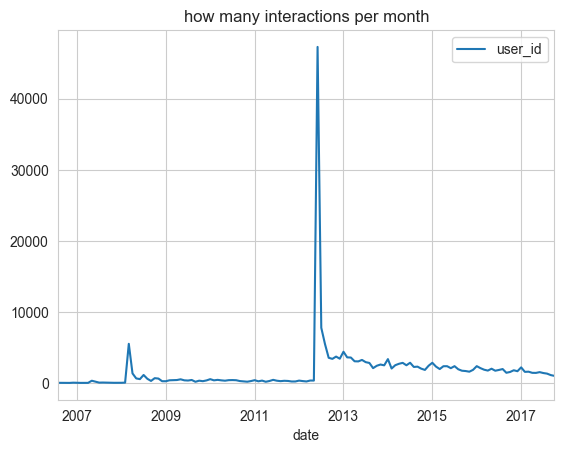

In [16]:
pos_inter[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

,user_id,book_id,is_read,is_reviewed,timestamp,date
216,8842281e1d1347389f2ab93d60773d4d,1969280,True,0,1.414814e+09,2014-11-01
217,8842281e1d1347389f2ab93d60773d4d,17290220,True,1,1.414814e+09,2014-11-01
219,8842281e1d1347389f2ab93d60773d4d,6882,True,0,1.412136e+09,2014-10-01
220,8842281e1d1347389f2ab93d60773d4d,6954929,True,1,1.412136e+09,2014-10-01
224,8842281e1d1347389f2ab93d60773d4d,18176747,True,1,1.412136e+09,2014-10-01


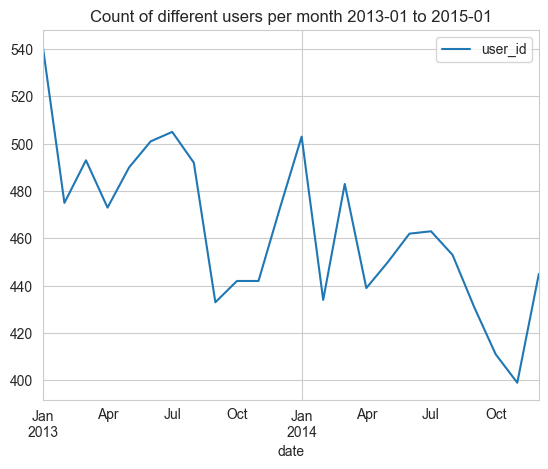

In [17]:
df_1315, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter, col=user_col, time_col=date_col)
df_1315.head()

In [23]:
_dict  = load_interactions_to_dict(head=int(100000/0.14)*4,
                                      rating=3,
                                      save_folder=output_path+'pos_rates_only/', 
                                      save_filename='inter_dedup_+3stars_4x714k',
                                      file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
_df = pd.DataFrame.from_dict(_dict, orient='index',columns=inter_dedup_columns)

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,complete
done!
number of lines  2857141
number of positive rates (>3 stars)  927880 0.3247582110928372
number of books  254311 0.0890089078557901
number of users  5632 0.001971201281280833


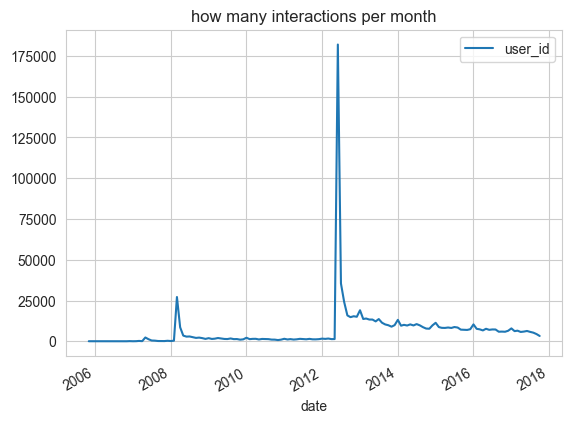

In [24]:
_df[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

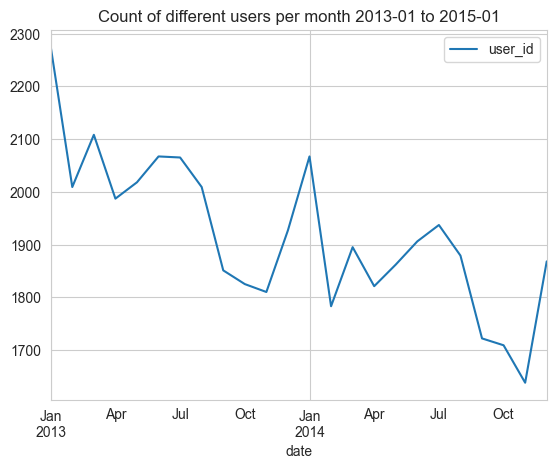

In [25]:
_, _, _, _ = sample_time_period(['2013-01','2015-01'], _df, col=user_col, time_col=date_col)

In [28]:
# pos_rates_folderpath = output_path+'pos_rates_only/'
# validate_folderpath(pos_rates_folderpath)

# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'


def load_interactions_within_period_to_dict(head, rating, save_folder, save_filename, file_foldername, period, time_format='%a %b %d %H:%M:%S %z %Y'):

    '''
        to load 'goodreads_interactions_dedup.json.gz'
    '''

    validate_folderpath(save_folder)

    print('counting file:', file_foldername)

    start_year, end_year = period

    n_lines, n_pos_rates = 0, 0
    book_set, user_set = set(), set()

    inter_dedup_dict = {}

    print('current line: ', end='')
    with gzip.open(file_foldername) as fin:
        for l in fin:
            d = json.loads(l)

            if (head is not None) and (n_lines > head):
                break
            
            if n_lines % 100000 == 0:
                print(n_lines, end=',')
            n_lines += 1
            
            date = datetime.strptime(d['date_added'], time_format)
            # if (date.year >= start_year) & (date.year <= end_year): 
            if start_year <= date.year <= end_year:
                # only positive ratings, 4 and 5 stars
                if d['rating'] > rating:
                    n_pos_rates += 1
                    
                    # date = datetime.strptime(d['date_added'], time_format)
                    date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
                    ts = datetime.timestamp(date)

                    is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

                    book_set.add(d['book_id'])
                    user_set.add(d['user_id'])

                    inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


    joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',n_lines)
    print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
    print('number of books ',len(book_set), len(book_set)/n_lines)
    print('number of users ',len(user_set), len(user_set)/n_lines)

    return inter_dedup_dict

In [31]:
int(100000/0.14)*4

2857140

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,complete
done!
number of lines  2857141
number of positive rates (>3 stars)  364979 0.12774273303277647
number of books  138937 0.04862798160818804
number of users  5102 0.0017857011607057545


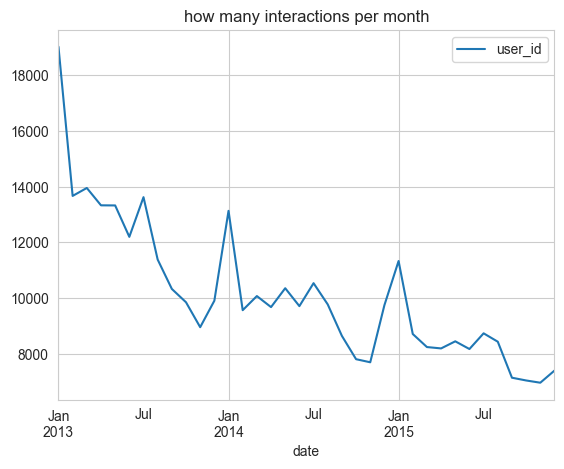

In [30]:
save_folder = output_path+'pos_rates_only/'
sample = 'inter_dedup_1315_+3stars_4x714k'
interd_2  = load_interactions_within_period_to_dict(head=int(100000/0.14)*4,
                                      rating=3,
                                      period=[2013, 2015],
                                      save_folder=save_folder, 
                                      save_filename=sample,
                                      file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
pos_inter_2 = pd.DataFrame.from_dict(interd_2, orient='index',columns=inter_dedup_columns)
pos_inter_2[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

In [35]:
print(save_folder)
print(sample)

output/goodreads_dump/pos_rates_only/
inter_dedup_1315_+3stars_4x714k


In [32]:
pos_inter_2.to_csv(save_folder+sample+'_df.csv')

0.0 %
25.0 %
50.0 %
75.0 %


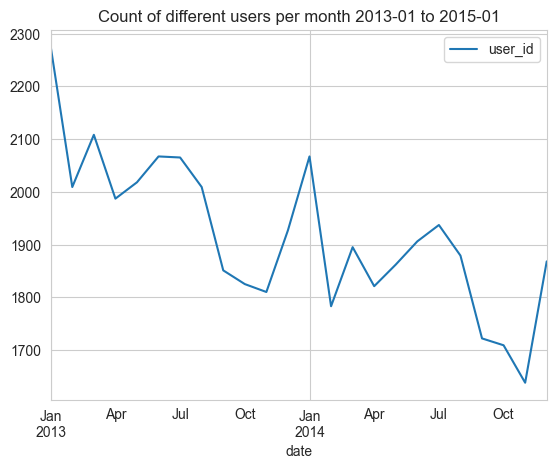

In [33]:
posint_1315, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter_2, col=user_col, time_col=date_col)

user_presence_df, user_month_interactions, \
    trimestres, user_trimestre_interactions, \
        semesters, user_semester_interactions = get_interactions_info(posint_1315, user_col, quarter_info=True, semester_info=True)

In [36]:
print(save_folder)
print(sample)

output/goodreads_dump/pos_rates_only/
inter_dedup_1315_+3stars_4x714k


In [37]:

joblib.dump(user_presence_df, save_folder+sample+'_user_presence_df.joblib')
joblib.dump(user_month_interactions, save_folder+sample+'_user_month_interactions.joblib')
joblib.dump(trimestres, save_folder+sample+'_trimestres.joblib')
joblib.dump(user_trimestre_interactions, save_folder+sample+'_user_trimestre_interactions.joblib')
joblib.dump(semesters, save_folder+sample+'_semesters.joblib')
joblib.dump(user_semester_interactions, save_folder+sample+'_user_semester_interactions.joblib')

thr=0.8
frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
joblib.dump(frequent_users, save_folder+sample+'_frequent_users_'+str(thr)+'.joblib')

589 users of 4908 (12.001%) occurr in 80.0% or more months.
1658 users of 4908 (33.782%) occurr in 80.0% or more quarters.
2302 users of 4908 (46.903%) occurr in 80.0% or more semesters.


['output/goodreads_dump/pos_rates_only/inter_dedup_1315_+3stars_4x714k_frequent_users_0.8.joblib']

In [38]:
def get_semester_info_with_user_thresh(print_timeperiod:str, usi:pd.DataFrame, semesters_idx:int, n_semester_thr:int):
    '''
        user threshold is 1 interaction in at least *n_semester_thr* semesters
    '''

    usi_sample = usi.loc[:,semesters_idx]

    # semester-frequent-users, presence in all semesters
    sfu_filter = (usi_sample>0).T.sum() >= n_semester_thr
    # in doubt? run:
    #         print((pd.Series([1, 1, 0])>0))
    #         print(pd.Series([True, True, False]).sum())
    #         print((pd.Series([1, 1, 0])>0).sum())
    #         print((pd.Series([1, 1, 0])>0).sum()>=2)

    fusi_sample = usi_sample[sfu_filter]

    print(str(fusi_sample.shape[0])+' users of '+str(usi_sample.shape[0])+' ('+str((fusi_sample.shape[0]/ usi_sample.shape[0])*100)+'%) in '+str((n_semester_thr/fusi_sample.shape[1])*100)+'% or more semesters in '+str(print_timeperiod)+' ('+str(fusi_sample.sum().sum())+' interactions)')

    print('\nNumber of interactions per semester in '+str(print_timeperiod)+':\n',fusi_sample.sum())

    return fusi_sample

In [42]:
frequent_users_2015_16_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2013 and 2014',
                                                                                  usi=user_semester_interactions,
                                                                                  semesters_idx=[0,1,2,3],
                                                                                  n_semester_thr=3)

frequent_users_2015_16_semester_interactions

3323 users of 4908 (67.70578647106764%) in 75.0% or more semesters in 2013 and 2014 (41433.0 interactions)

Number of interactions per semester in 2013 and 2014:
 0    10733.0
1    10497.0
2    10460.0
3     9743.0
dtype: float64


,0,1,2,3
001aa4da5b2c1c53765b168224c7f106,6.0,3.0,2.0,3.0
c7bf6a3d7a6023e1c5eb4d7fb62eeff2,6.0,4.0,4.0,5.0
69bb9d5f86547bf4cc5c1aaedf77674b,1.0,4.0,3.0,4.0
69db0e5bd0d5628650fec27c460a6053,3.0,6.0,6.0,4.0
69e162e8748e8cac380d31cb27db6f53,6.0,6.0,5.0,4.0
...,...,...,...,...
05f80b91ceee2d696dd8155a781a3b52,0.0,1.0,2.0,1.0
c4b5fd2c733469fc3e83e86ccfd6ce37,0.0,1.0,1.0,1.0
2ae22eea2db77997c2b9580edef67eaf,0.0,1.0,4.0,5.0
0e75906f4c610dc7e1298470c616a325,0.0,1.0,6.0,6.0


# get all genres

___
## proof code works

In [ ]:
# _ = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=1000))
# _

In [ ]:
# _.columns

In [ ]:
# 'genres.history, historical fiction, biography'[len('genres.'):].split(', ')

In [ ]:
# _list = [c[len('genres.'):].split(', ') for c in _.columns[1:]]
# import itertools
# merged = list(itertools.chain(*_list))
# merged

In [ ]:
# [c[len('genres.'):] for c in _.columns[1:]]

end of code proof
___

In [33]:
book_genres = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=None))
book_genres

,book_id,"genres.history, historical fiction, biography",genres.fiction,"genres.fantasy, paranormal","genres.mystery, thriller, crime",genres.poetry,genres.romance,genres.non-fiction,genres.children,genres.young-adult,"genres.comics, graphic"
0,5333265,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1333909,5.0,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7327624,NaN,8.0,31.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,6066819,NaN,555.0,NaN,10.0,NaN,23.0,NaN,NaN,NaN,NaN
4,287140,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2360651,26168430,NaN,1.0,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN
2360652,2342551,NaN,NaN,NaN,NaN,14.0,NaN,1.0,7.0,1.0,NaN
2360653,22017381,NaN,NaN,NaN,2.0,NaN,13.0,NaN,NaN,NaN,NaN


In [26]:
item_meta_list = [c[len('genres.'):] for c in book_genres.columns[1:]]
item_meta_list

['history, historical fiction, biography',
 'fiction',
 'fantasy, paranormal',
 'mystery, thriller, crime',
 'poetry',
 'romance',
 'non-fiction',
 'children',
 'young-adult',
 'comics, graphic']

In [34]:
book_genres_clean = book_genres.replace(to_replace=np.NaN, value=0)
book_genres_clean

,book_id,"genres.history, historical fiction, biography",genres.fiction,"genres.fantasy, paranormal","genres.mystery, thriller, crime",genres.poetry,genres.romance,genres.non-fiction,genres.children,genres.young-adult,"genres.comics, graphic"
0,5333265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1333909,5.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7327624,0.0,8.0,31.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6066819,0.0,555.0,0.0,10.0,0.0,23.0,0.0,0.0,0.0,0.0
4,287140,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2360651,26168430,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
2360652,2342551,0.0,0.0,0.0,0.0,14.0,0.0,1.0,7.0,1.0,0.0
2360653,22017381,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0


In [35]:
book_genres_clean.count(axis=1)

0          11
1          11
2          11
3          11
4          11
           ..
2360650    11
2360651    11
2360652    11
2360653    11
2360654    11
Length: 2360655, dtype: int64

In [37]:
book_genres_clean['genre_count'] = _.count(axis=1)

In [41]:
book_genres_clean.columns = ['book_id'] + item_meta_list + ['genre_count']
book_genres_clean

,book_id,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic",genre_count
0,5333265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1333909,5.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,7327624,0.0,8.0,31.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5
3,6066819,0.0,555.0,0.0,10.0,0.0,23.0,0.0,0.0,0.0,0.0,4
4,287140,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3
2360651,26168430,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,4
2360652,2342551,0.0,0.0,0.0,0.0,14.0,0.0,1.0,7.0,1.0,0.0,5
2360653,22017381,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0,3
